# Optimize the Autoregressive RNN with continuous input
- This model is autoregressive, which means that the prediction of the last time step is the input of the current time step. This way the model can predict a varying number of steps into the future without retraining
- Some features, like time and weather, are fed into the model from outside even during prediction phase so the model does not have to predict those by itself

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [14]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150

sns.set_theme()

### Import data

In [15]:
df = pd.read_csv('..\data\prepared\elec_time_pca-wx_combined.csv', parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])
df.head()


,prod_wind,prod_solar,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7
2017-01-01 00:00:00+00:00,15498.0,0.0,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0,-9.852558,15.288176,4.347648,-2.309275,-6.504426,1.835412,-2.912726,-1.002096
2017-01-01 01:00:00+00:00,15406.9,0.0,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0,-10.402722,14.609254,4.218358,-2.001596,-6.243442,1.721510,-3.024547,-1.148866
2017-01-01 02:00:00+00:00,14922.3,0.0,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0,-10.671664,14.329923,3.502013,-1.374882,-6.517594,1.778085,-2.993373,-1.056570
2017-01-01 03:00:00+00:00,15022.0,0.0,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0,-11.211067,13.624351,3.435171,-1.067060,-6.467290,1.582473,-3.276953,-1.139719
2017-01-01 04:00:00+00:00,15234.0,0.0,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0,-11.712684,12.801144,3.789605,-1.089136,-6.811083,1.742942,-3.311717,-0.915913


### Split the data
- 70% training
- 20% validation
- 10% test

In [16]:
from sklearn.preprocessing import MinMaxScaler

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

scaler = MinMaxScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

len(df_train.columns)

16

### Normalize the data

### Data Windowing
#### 1. Indexes and offsets

- Windows Generator that can create multiple inputs, one for the inputs that are only known in the past (power production) and one for inputs that are also known in the future (time and weather)

In [17]:
class WindowGenerator():
    def __init__(self, past_width, future_width,
                 label_columns, precise_columns=None, forecast_columns=None,
                 train_df=df_train, val_df=df_val, test_df=df_test):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Check if length of provided features match with data frame
        num_columns = 0
        num_columns += len(label_columns)
        if precise_columns is not None:
            num_columns += len(precise_columns)
        if forecast_columns is not None:
            num_columns += len(forecast_columns)
        assert num_columns == len(train_df.columns), \
            "Length of provided label, precise, and forecast features do not match data frame"

        # Work out the column indices
        self.columns_indices = {name: i for i, name in
                                enumerate(train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
        self.precise_columns = precise_columns
        self.forecast_columns = forecast_columns

        # Work out the window parameters.
        self.past_width = past_width
        self.future_width = future_width

        self.total_window_size = past_width + future_width

        self.input_past_slice = slice(0, past_width)
        self.input_past_indices = np.arange(self.total_window_size)[
            self.input_past_slice]

        self.input_future_slice = slice(self.past_width, -1)
        self.input_future_indices = np.arange(self.total_window_size)[
            self.input_future_slice]

        self.label_slice = slice(self.past_width, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.label_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size:    {self.total_window_size}',
            f'Input past indices:   {self.input_past_indices}',
            f'Input future indices: {self.input_future_indices}',
            f'Label indices:        {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        # f'Precise column name(s):  {self.precise_columns}',
        # f'Forecast column name(s): {self.forecast_columns}'])


#### 2. Split

In [18]:
def split_window(self, features):
    # Past: All inputs are known
    inputs_past = features[:, self.input_past_slice, :]

    # Future: Only precise and forecast inputs are known
    if self.precise_columns is None:
        self.precise_columns = []
    if self.forecast_columns is None:
        self.forecast_columns = []
    self.input_future_columns = self.precise_columns + self.forecast_columns

    inputs_future = tf.stack(
        [features[:, self.input_future_slice, self.columns_indices[name]]
            for name in self.input_future_columns],
        axis=-1)

    labels = tf.stack(
        [features[:, self.label_slice, self.columns_indices[name]]
            for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs_past.set_shape([None, self.past_width, None])
    inputs_future.set_shape([None, self.future_width-1, None])
    labels.set_shape([None, self.future_width, None])

    # Return inputs and labels
    # The past and future input tuple will be unpacked in the model.call() method
    return (inputs_past, inputs_future), labels


WindowGenerator.split_window = split_window


#### 3. Plot

In [19]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    (inputs_past, inputs_future) = inputs
    plt.figure(figsize=(12, 8))
    plot_col_index = self.columns_indices[plot_col]
    max_n = min(max_subplots, len(inputs_past))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)

        # Plot past inputs
        plt.plot(self.input_past_indices, inputs_past[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        label_col_index = self.label_columns_indices.get(plot_col, None)

        # Add last point of past array to future arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_past_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs_past[n, :, plot_col_index][-1])

        # Plot labels
        plt.plot(label_indices_plot, labels_plot,
                 'C2', label='Labels', marker='.', zorder=1)

        # Plot prediction
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs_past[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        # x Ticks every 6 hours
        plt.xticks(np.arange(self.input_past_indices[0], self.label_indices[-1]+2, 6))

        plt.ylabel(f'{plot_col} [normed]')
        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot


#### 4. Create `tf.data.Datasets`

In [20]:
def make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


In [21]:
@property
def train(self):
    self._train = self.make_dataset(self.train_df)
    return self._train

# @train.setter
# def train(self, value):
#     self._train = value


@property
def val(self):
    self._val = self.make_dataset(self.val_df)
    return self._val

# @val.setter
# def val(self, value):
#     self._val = value


@property
def test(self):
    self._test = self.make_dataset(self.test_df)
    return self._test

# Setting of test property not allowed


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.test` dataset
        result = next(iter(self.test))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


## Window creation

In [22]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = [col for col in df if col.startswith('pca_')]

PAST_STEPS = 24
PREDICTION_STEPS = 12

window = WindowGenerator(
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features
)

window


Total window size:    36
Input past indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Input future indices: [24 25 26 27 28 29 30 31 32 33 34]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['prod_wind', 'prod_solar']

Now, the `WindowGenerator` object gives access to the tf.data.Dataset objects, to easily iterate over the data.

The `Dataset.element_spec` property tells the structure, data types, and shapes of the dataset elements.

In [23]:
window.train.element_spec

((TensorSpec(shape=(None, 24, 16), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 11, 14), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 12, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [24]:
for (example_inputs_past, example_inputs_future), example_labels in window.train.take(1):
  print(f'Inputs past shape (batch, time, features): {example_inputs_past.shape}')
  print(f'Inputs fut. shape (batch, time, features): {example_inputs_future.shape}')
  print(f'Labels shape      (batch, time, features): {example_labels.shape}')

Inputs past shape (batch, time, features): (32, 24, 16)
Inputs fut. shape (batch, time, features): (32, 11, 14)
Labels shape      (batch, time, features): (32, 12, 2)


Plot an example window:

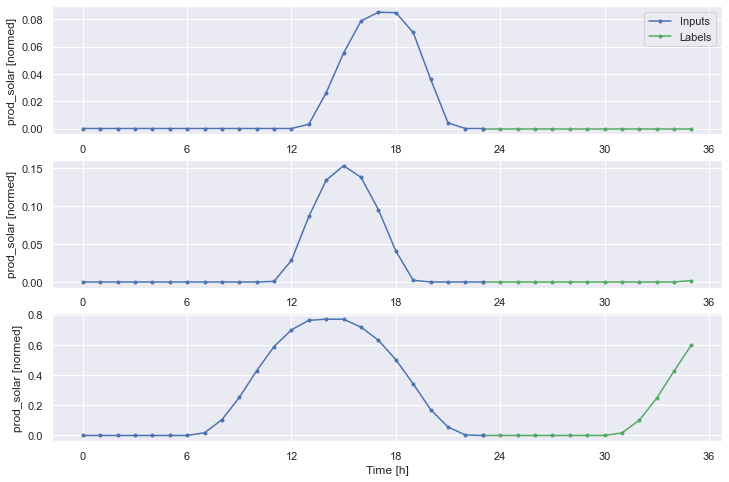

In [25]:
window.plot(plot_col="prod_solar")
# multi_window.plot(plot_col="prod_wind")

## Autoregressive LSTM
The model predicts individual time steps that are fed back into itself, so that the model can produce output with a varying length.
This is implemented in the custom model class `AutoRegressiveRNN`.

In [26]:
class AutoRegressiveRNN(tf.keras.Model):
    def __init__(self, units: list, out_steps: int, rnn_type="LSTM"):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.type = rnn_type
        self.rnn_cells = []
        self.rnn_layers = []
        if rnn_type == "LSTM":
            for unit in self.units:
                    self.rnn_cells.append(tf.keras.layers.LSTMCell(unit))
        elif rnn_type == "GRU":
            for unit in self.units:
                    self.rnn_cells.append(tf.keras.layers.GRUCell(unit))
        else:
            raise AssertionError("Unknown type")
        # match rnn_type:
        #     case "LSTM":
        #         for unit in self.units:
        #             self.rnn_cells.append(tf.keras.layers.LSTMCell(unit))
        #     case "GRU":
        #         for unit in self.units:
        #             self.rnn_cells.append(tf.keras.layers.GRUCell(unit))
        #     case other:
        #         raise AssertionError("Unknown type")
        # Wrap the cells in an RNN to simplify the `warmup` method.
        for i, rnn_cell in enumerate(self.rnn_cells):
            # If last layer: Do not return sequences
            if i == len(self.rnn_cells)-1:
                self.rnn_layers.append(tf.keras.layers.RNN(
                    rnn_cell, return_sequences=False, return_state=True))
            else:
                self.rnn_layers.append(tf.keras.layers.RNN(
                    rnn_cell, return_sequences=True, return_state=True))
        self.dense = tf.keras.layers.Dense(num_predictions)


#### Model warmup
The warmup method initializes the model's internal state based on the full input from the past (power data, time and weather)

In [27]:
def warmup(self, x):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    states = []
    for rnn_layer in self.rnn_layers:
        x, *state = rnn_layer(x)
        states.append(state)
    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, states


AutoRegressiveRNN.warmup = warmup


#### Model call
A custom call is used to feed the model the full input from the past during warmup and then only the time and weather forecast during the prediction phase, where the model takes the prediction from the last time step to substitute the missing input.

In [28]:
def call(self, inputs, training=None):
    # unpack the past and future inputs
    inputs_past, inputs_future = inputs
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Past phase: Initialize the RNN state
    prediction, states = self.warmup(inputs_past)
    # Insert the first prediction.
    predictions.append(prediction)

    # Future phase: Run the rest of the prediction steps
    for n in range(self.out_steps-1):
        # Select the known input at the current time step
        input_future = inputs_future[:, n, :]
        # Use the last prediction as unknown input and combine it with the known input
        # x.shape => (batch, features)
        x = tf.concat([prediction, input_future], axis=1)
        # Execute one RNN step.
        for i, rnn_cell in enumerate(self.rnn_cells):
            x, states[i] = rnn_cell(x, states=states[i],
                                    training=training)
        # Convert the RNN output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


AutoRegressiveRNN.call = call


#### Training procedure

In [29]:
from tensorflow_addons.metrics.r_square import RSquare
import os


def check_for_weights(model, checkpoint_dir):
    # Restore latest model weights, if available
    checkpoints = [checkpoint_dir + "/" +
                   name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring weights from", latest_checkpoint)
        model.load_weights(latest_checkpoint)
        return
    print("No saved weights found")
    return


def compile_and_fit(model, window, learning_rate, epochs=100, save=False, stop_early=True, model_name=None, patience=10, verbose='auto'):
    callbacks = []
    if save:
        assert model_name is not None, "No model name provided"
        # Prepare directory to save model
        checkpoint_dir = '../models/'+model_name
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        # Load weights
        
        check_for_weights(model, checkpoint_dir)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + '/' + model_name + '_weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True)
        callbacks.append(model_checkpoint)

    if stop_early:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=patience,
                                                          mode='min',
                                                          verbose=1,
                                                          restore_best_weights=True)
        callbacks.append(early_stopping)

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse'), RSquare()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=callbacks,
                        verbose=verbose)
    return history


val_performance = {}
test_performance = {}
history = {}


In [30]:
def model_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation loss (MSE)')
    # plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')


## Hyperparameter optimization with optuna

In [31]:
import optuna as optuna
def objective(trial):

    params = {
            'past_steps': trial.suggest_int("past_steps",4,96),
              'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
              # number of layers
              'n_layers': trial.suggest_int("n_layers", 1, 3)
              #'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    # vary number of past_steps
    window = WindowGenerator(
        past_width=params['past_steps'], future_width=PREDICTION_STEPS,
        label_columns=prediction_features,
        precise_columns=precise_features,
        forecast_columns=forecast_features
    )

    # enable sampling of layers and units in each layer
    units_list=[None] * params['n_layers']

    for i in range(params['n_layers']):
        # Suggest the number of units in each layer
        n_units = trial.suggest_int("n_units_l{}".format(i), 4, 32)
        units_list[i]=n_units
        
        
    # build model with giiven parametres
    arlstm_model = AutoRegressiveRNN(units=units_list, out_steps=PREDICTION_STEPS, rnn_type="GRU")
    history = compile_and_fit(arlstm_model, window, epochs=50,learning_rate=params['learning_rate'], verbose=0)
    
    # get test performance as study criterion
    test_performance = arlstm_model.evaluate(window.test, verbose=2)
    
            
    # return the test_performance loss which is the first element
    return test_performance[0]

In [32]:
# study hyperparameters
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=25)

[I 2022-10-13 17:40:54,094] A new study created in memory with name: no-name-eb8bf962-3688-4628-8681-550c037c00de


Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
136/136 - 0s - loss: 0.0025 - mae: 0.0351 - rmse: 0.0502 - r_square: 0.9427 - 432ms/epoch - 3ms/step


[I 2022-10-13 17:43:41,863] Trial 0 finished with value: 0.0025249349419027567 and parameters: {'past_steps': 38, 'learning_rate': 0.06521887594197735, 'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 14}. Best is trial 0 with value: 0.0025249349419027567.


Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
135/135 - 1s - loss: 0.0024 - mae: 0.0344 - rmse: 0.0494 - r_square: 0.9441 - 869ms/epoch - 6ms/step


[I 2022-10-13 17:51:51,367] Trial 1 finished with value: 0.0024404707364737988 and parameters: {'past_steps': 66, 'learning_rate': 0.047552176128676536, 'n_layers': 3, 'n_units_l0': 5, 'n_units_l1': 21, 'n_units_l2': 26}. Best is trial 1 with value: 0.0024404707364737988.


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
135/135 - 1s - loss: 0.0019 - mae: 0.0299 - rmse: 0.0436 - r_square: 0.9561 - 789ms/epoch - 6ms/step


[I 2022-10-13 17:58:12,019] Trial 2 finished with value: 0.001901788404211402 and parameters: {'past_steps': 63, 'learning_rate': 0.024736129913437998, 'n_layers': 3, 'n_units_l0': 9, 'n_units_l1': 12, 'n_units_l2': 10}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
137/137 - 0s - loss: 0.0023 - mae: 0.0326 - rmse: 0.0476 - r_square: 0.9494 - 306ms/epoch - 2ms/step


[I 2022-10-13 17:59:50,207] Trial 3 finished with value: 0.002263881266117096 and parameters: {'past_steps': 7, 'learning_rate': 0.08419517209843527, 'n_layers': 3, 'n_units_l0': 23, 'n_units_l1': 13, 'n_units_l2': 32}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
134/134 - 0s - loss: 0.0021 - mae: 0.0327 - rmse: 0.0460 - r_square: 0.9513 - 469ms/epoch - 3ms/step


[I 2022-10-13 18:03:19,184] Trial 4 finished with value: 0.002111614216119051 and parameters: {'past_steps': 88, 'learning_rate': 0.04891390871941337, 'n_layers': 1, 'n_units_l0': 24}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
135/135 - 1s - loss: 0.0039 - mae: 0.0415 - rmse: 0.0628 - r_square: 0.9131 - 989ms/epoch - 7ms/step


[I 2022-10-13 18:11:02,282] Trial 5 finished with value: 0.0039383056573569775 and parameters: {'past_steps': 79, 'learning_rate': 0.07214976246207284, 'n_layers': 3, 'n_units_l0': 18, 'n_units_l1': 27, 'n_units_l2': 26}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
135/135 - 1s - loss: 0.0024 - mae: 0.0347 - rmse: 0.0485 - r_square: 0.9461 - 850ms/epoch - 6ms/step


[I 2022-10-13 18:17:19,604] Trial 6 finished with value: 0.002355410484597087 and parameters: {'past_steps': 69, 'learning_rate': 0.06237349690592143, 'n_layers': 3, 'n_units_l0': 5, 'n_units_l1': 15, 'n_units_l2': 18}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping
136/136 - 0s - loss: 0.0025 - mae: 0.0349 - rmse: 0.0500 - r_square: 0.9420 - 320ms/epoch - 2ms/step


[I 2022-10-13 18:19:28,579] Trial 7 finished with value: 0.0024979724548757076 and parameters: {'past_steps': 45, 'learning_rate': 0.079630050634901, 'n_layers': 1, 'n_units_l0': 13}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping
135/135 - 1s - loss: 0.0020 - mae: 0.0311 - rmse: 0.0448 - r_square: 0.9533 - 822ms/epoch - 6ms/step


[I 2022-10-13 18:26:10,610] Trial 8 finished with value: 0.0020098502282053232 and parameters: {'past_steps': 57, 'learning_rate': 0.015078887334186613, 'n_layers': 3, 'n_units_l0': 10, 'n_units_l1': 29, 'n_units_l2': 20}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping
135/135 - 0s - loss: 0.0032 - mae: 0.0411 - rmse: 0.0563 - r_square: 0.9295 - 336ms/epoch - 2ms/step


[I 2022-10-13 18:30:00,941] Trial 9 finished with value: 0.0031745261512696743 and parameters: {'past_steps': 54, 'learning_rate': 0.04720381688392483, 'n_layers': 1, 'n_units_l0': 4}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping
136/136 - 0s - loss: 0.0021 - mae: 0.0304 - rmse: 0.0453 - r_square: 0.9529 - 366ms/epoch - 3ms/step


[I 2022-10-13 18:33:37,184] Trial 10 finished with value: 0.0020508498419076204 and parameters: {'past_steps': 26, 'learning_rate': 0.010093660262451227, 'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 4}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping
135/135 - 1s - loss: 0.0023 - mae: 0.0326 - rmse: 0.0479 - r_square: 0.9478 - 569ms/epoch - 4ms/step


[I 2022-10-13 18:39:06,650] Trial 11 finished with value: 0.002297885250300169 and parameters: {'past_steps': 59, 'learning_rate': 0.01314634060634286, 'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 32}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping
136/136 - 1s - loss: 0.0023 - mae: 0.0329 - rmse: 0.0475 - r_square: 0.9484 - 528ms/epoch - 4ms/step


[I 2022-10-13 18:44:37,199] Trial 12 finished with value: 0.0022542616352438927 and parameters: {'past_steps': 32, 'learning_rate': 0.023005417075735796, 'n_layers': 3, 'n_units_l0': 10, 'n_units_l1': 7, 'n_units_l2': 4}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping
135/135 - 1s - loss: 0.0021 - mae: 0.0304 - rmse: 0.0457 - r_square: 0.9519 - 943ms/epoch - 7ms/step


[I 2022-10-13 18:54:35,320] Trial 13 finished with value: 0.002084736479446292 and parameters: {'past_steps': 78, 'learning_rate': 0.026164282698424926, 'n_layers': 3, 'n_units_l0': 14, 'n_units_l1': 21, 'n_units_l2': 9}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 33.
Epoch 43: early stopping
136/136 - 1s - loss: 0.0023 - mae: 0.0319 - rmse: 0.0475 - r_square: 0.9496 - 524ms/epoch - 4ms/step


[I 2022-10-13 19:05:22,952] Trial 14 finished with value: 0.002258127089589834 and parameters: {'past_steps': 50, 'learning_rate': 0.0005120361115207792, 'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 28}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping
136/136 - 0s - loss: 0.0022 - mae: 0.0311 - rmse: 0.0466 - r_square: 0.9507 - 431ms/epoch - 3ms/step


[I 2022-10-13 19:10:20,937] Trial 15 finished with value: 0.0021738866344094276 and parameters: {'past_steps': 21, 'learning_rate': 0.03273302782853675, 'n_layers': 3, 'n_units_l0': 17, 'n_units_l1': 9, 'n_units_l2': 16}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
135/135 - 1s - loss: 0.0022 - mae: 0.0338 - rmse: 0.0470 - r_square: 0.9497 - 596ms/epoch - 4ms/step


[I 2022-10-13 19:15:05,661] Trial 16 finished with value: 0.0022049264516681433 and parameters: {'past_steps': 65, 'learning_rate': 0.0361310268029145, 'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 19}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping
134/134 - 1s - loss: 0.0019 - mae: 0.0300 - rmse: 0.0437 - r_square: 0.9553 - 1s/epoch - 8ms/step


[I 2022-10-13 19:24:06,113] Trial 17 finished with value: 0.0019119433127343655 and parameters: {'past_steps': 88, 'learning_rate': 0.01537050765469881, 'n_layers': 3, 'n_units_l0': 15, 'n_units_l1': 25, 'n_units_l2': 12}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
134/134 - 1s - loss: 0.0248 - mae: 0.1056 - rmse: 0.1575 - r_square: 0.4203 - 1s/epoch - 9ms/step


[I 2022-10-13 19:33:13,611] Trial 18 finished with value: 0.024808647111058235 and parameters: {'past_steps': 95, 'learning_rate': 0.09958921470174159, 'n_layers': 3, 'n_units_l0': 22, 'n_units_l1': 23, 'n_units_l2': 11}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping
135/135 - 1s - loss: 0.0020 - mae: 0.0311 - rmse: 0.0445 - r_square: 0.9540 - 755ms/epoch - 6ms/step


[I 2022-10-13 19:38:36,138] Trial 19 finished with value: 0.0019821985624730587 and parameters: {'past_steps': 80, 'learning_rate': 0.031971127586960676, 'n_layers': 2, 'n_units_l0': 28, 'n_units_l1': 24}. Best is trial 2 with value: 0.001901788404211402.


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
134/134 - 1s - loss: 0.0017 - mae: 0.0283 - rmse: 0.0418 - r_square: 0.9598 - 1s/epoch - 8ms/step


[I 2022-10-13 19:56:49,284] Trial 20 finished with value: 0.0017433129251003265 and parameters: {'past_steps': 92, 'learning_rate': 0.0017331710148084344, 'n_layers': 3, 'n_units_l0': 15, 'n_units_l1': 10, 'n_units_l2': 11}. Best is trial 20 with value: 0.0017433129251003265.


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping
134/134 - 1s - loss: 0.0018 - mae: 0.0292 - rmse: 0.0429 - r_square: 0.9580 - 1s/epoch - 10ms/step


[I 2022-10-13 20:15:54,908] Trial 21 finished with value: 0.001836602226831019 and parameters: {'past_steps': 96, 'learning_rate': 0.002572788812340481, 'n_layers': 3, 'n_units_l0': 15, 'n_units_l1': 11, 'n_units_l2': 11}. Best is trial 20 with value: 0.0017433129251003265.


134/134 - 1s - loss: 0.0021 - mae: 0.0318 - rmse: 0.0460 - r_square: 0.9524 - 1s/epoch - 8ms/step


[I 2022-10-13 20:47:43,606] Trial 22 finished with value: 0.002113328082486987 and parameters: {'past_steps': 94, 'learning_rate': 0.0006161255044993181, 'n_layers': 3, 'n_units_l0': 16, 'n_units_l1': 10, 'n_units_l2': 6}. Best is trial 20 with value: 0.0017433129251003265.


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping
135/135 - 1s - loss: 0.0020 - mae: 0.0301 - rmse: 0.0451 - r_square: 0.9534 - 1s/epoch - 9ms/step


[I 2022-10-13 21:01:16,958] Trial 23 finished with value: 0.002029985189437866 and parameters: {'past_steps': 73, 'learning_rate': 0.006550263814084388, 'n_layers': 3, 'n_units_l0': 12, 'n_units_l1': 11, 'n_units_l2': 15}. Best is trial 20 with value: 0.0017433129251003265.


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping
134/134 - 1s - loss: 0.0020 - mae: 0.0303 - rmse: 0.0445 - r_square: 0.9543 - 1s/epoch - 8ms/step


[I 2022-10-13 21:14:22,700] Trial 24 finished with value: 0.001981812994927168 and parameters: {'past_steps': 86, 'learning_rate': 0.024214708276138704, 'n_layers': 3, 'n_units_l0': 20, 'n_units_l1': 6, 'n_units_l2': 8}. Best is trial 20 with value: 0.0017433129251003265.


In [33]:
# save study and best values
import joblib
joblib.dump(study, '../optuna/study_arlstm_model.pkl')

print('best_value:', study.best_value)
with open('../optuna/best_trial_arlstm_model.txt', 'w') as f:
    print(study.best_trial, file=f)

best_value: 0.0017433129251003265


In [34]:
# Visualization of hyperparameter optimization
import kaleido
import plotly

fig = optuna.visualization.plot_parallel_coordinate(study, 
    params=['learning_rate', 'n_layers', 'past_steps']) 
fig.update_layout(
    title=None,
    font=dict(
        family='serif',
        size=10,
    ))
# save image
fig.write_image('../reports/optuna_parallel_coordinates.jpg')
fig.show()

#### Buid NN with optimized hyperparameters

In [ ]:
# study = joblib.load('./optuna/study_Adam.pkl')

# hyperparams['lr'] = study.best_params['learning rate']
# hyperparams['betas'] = (study.best_params['beta1'], study.best_params['beta2']) # Adam
# hyperparams['eps'] = study.best_params['epsilon']                               # Adam
# # hyperparams['momentum'] = study.best_params['momentum']                         # SGD                               
# hyperparams['weight_decay'] = study.best_params['weight decay']

# # model_name = 'ARLSTM 32'
# # history[model_name] = compile_and_fit(arlstm_model, window, model_name='ARLSTM32', verbose=2)
# # # IPython.display.clear_output()

# # val_performance[model_name] = arlstm_model.evaluate(window.val, verbose=0)
# # test_performance[model_name] = arlstm_model.evaluate(window.test, verbose=1)

# # window.plot(arlstm_model, plot_col="prod_wind")